In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from lifelines.datasets import load_waltons
df = load_waltons() 

In [2]:
df['group'].unique()

array(['miR-137', 'control'], dtype=object)

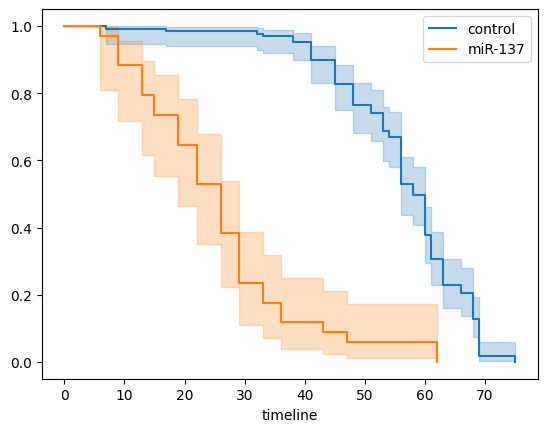

In [3]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
group_dfs = []
for name, grouped_df in df.groupby('group'):
    group_dfs.append(grouped_df)
    kmf.fit(grouped_df['T'], grouped_df['E'], label=name)
    kmf.plot_survival_function()

In [4]:
from lifelines.statistics import logrank_test, multivariate_logrank_test

t0 = 20
res = logrank_test(
    group_dfs[0]["T"], 
    group_dfs[1]["T"],
    group_dfs[0]["E"],
    group_dfs[1]["E"],
    t_0=t0
)
res.test_statistic

41.8595583505775

In [5]:
Nij = [[], []]
Oij = [[], []]
for i in range(2):
    gdf = group_dfs[i]
    for j in range(t0+1):
        Nij[i].append(gdf.loc[gdf['T'] >= j].shape[0])
        # Oij[i].append(gdf.loc[(gdf['T'] < j + 1e-5) & gdf['E']].shape[0])
        Oij[i].append(gdf.loc[(np.abs(gdf['T'] - j) < 1e-5) & gdf['E']].shape[0])
Nij = np.array(Nij)
Oij = np.array(Oij)
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
test_stat = np.sum(Oij - Eij, axis=1) ** 2 / np.sum(Vij, axis=1)
test_stat[0]

41.85955835057754

In [6]:
import scipy.stats
rvs = scipy.stats.expon.rvs(size=(10, 2))
control_rvs = rvs[:,0] 
hazard_ratio = 0.7
treatment_rvs = rvs[:,1] / hazard_ratio

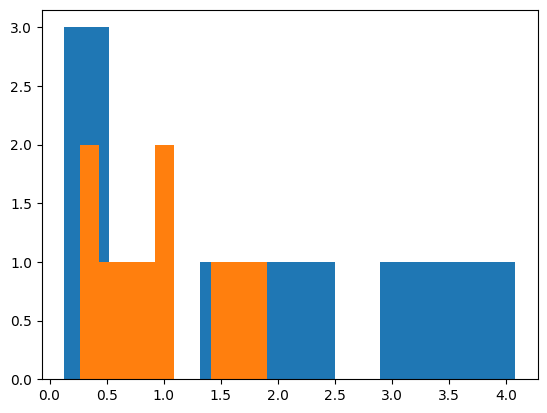

In [7]:
plt.hist(treatment_rvs)
plt.hist(control_rvs)
plt.show()

In [87]:
censoring_time = 2
all_rvs = np.concatenate([control_rvs, treatment_rvs])
group = np.concatenate([np.zeros(control_rvs.shape[0]), np.ones(treatment_rvs.shape[0])]).astype(bool)

In [88]:
ordering = np.argsort(all_rvs)
ordered_group = group[ordering]
ordered = all_rvs[ordering]
Nij = [[], []]
Oij = [[], []]
events_so_far = [0, 0]
max_idx = np.argmin(ordered <= censoring_time)
for j in range(max_idx):
    for i in range(2):
        event_now = ordered_group[j] == (i == 1)
        Nij[i].append(rvs.shape[0] - events_so_far[i])
        Oij[i].append(event_now)
        events_so_far[i] += event_now
Nij = np.array(Nij)
Oij = np.array(Oij)
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
test_stat = np.sum(Oij - Eij, axis=1) ** 2 / np.sum(Vij, axis=1)
test_stat[0]

2.414067815518945

In [89]:
multivariate_logrank_test(ordered, ordered_group, t0=4).test_statistic

2.414067815518944

In [90]:
ordering = jnp.argsort(all_rvs)
ordered = all_rvs[ordering]
ordered_group = group[ordering]
max_idx = jnp.argmin(ordered <= censoring_time)
event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * (jnp.arange(ordered.shape[0]) < max_idx)
events_so_far = jnp.concatenate((jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1)
Nij = rvs.shape[0] - events_so_far
Oij = event_now
Nj = Nij.sum(axis=0)
Oj = Oij.sum(axis=0)
Eij = Nij * (Oj / Nj)
Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
test_stat = jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / jnp.sum(Vij[0], axis=0)

In [91]:
test_stat

DeviceArray(2.4140677, dtype=float32)

In [92]:
@jax.vmap
@jax.jit
def logrank_test(all_rvs, group):
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    max_idx = jnp.argmin(ordered <= censoring_time)
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * (jnp.arange(ordered.shape[0]) < max_idx)
    events_so_far = jnp.concatenate((jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1)
    Nij = rvs.shape[0] - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    test_stat = jnp.sum(Oij[0] - Eij[0], axis=0) ** 2 / jnp.sum(Vij[0], axis=0)
    return test_stat

logrank_test(jnp.array([all_rvs]), jnp.array([group]))

DeviceArray([2.4140673], dtype=float32)

In [93]:
rvs = scipy.stats.expon.rvs(size=(100000, 10, 2))
control_rvs = rvs[:,:,0] 
hazard_rate = 0.7
treatment_rvs = rvs[:,:,1] / hazard_rate
all_rvs = np.concatenate([control_rvs, treatment_rvs], axis=1)
group = np.concatenate([np.zeros(control_rvs.shape), np.ones(treatment_rvs.shape)], axis=1).astype(bool)

In [96]:
%%time
logrank_test(all_rvs, group)

CPU times: user 166 ms, sys: 9.29 ms, total: 176 ms
Wall time: 151 ms


DeviceArray([0.00000000e+00, 1.12805765e-10, 7.69215375e-02, ...,
             5.88364899e-02, 5.88270649e-02, 5.29390574e-01],            dtype=float32)

In [146]:
0.008 / rvs.shape[0] * 1e9

80.0

In [ ]:
# The model here is survival analysis:
# - recruit n patients at t=0
# - observe them until censoring_time.
class LogRank:
    def __init__(self, seed, max_K, *, n, censoring_time):
        
        self.censoring_time